In [1]:
#Standard python imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

#Stats imports
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.stats.multicomp as mc
import scipy.stats as stats

#random seed for replicability
np.random.seed(seed=42)

In [2]:
atl_df = pd.read_csv('../data/atl_df_cleaned.csv')
atl_df.head(2)

,severity,start_lat,start_lng,end_lat,end_lng,distance(mi),temperature(f),wind_chill(f),humidity(%),pressure(in),...,weather_condition_Light Snow and Sleet,weather_condition_Haze / Windy,weather_condition_Heavy Snow,weather_condition_Freezing Rain,weather_condition_Heavy Snow / Windy,weather_condition_Light Freezing Fog,weather_condition_Blowing Dust / Windy,weather_condition_Heavy Blowing Snow,weather_condition_Light Freezing Drizzle,is_DST
0,3,32.83752,-83.64864,32.840424,-83.646307,0.242,66.0,66.0,90.0,29.79,...,0,0,0,0,0,0,0,0,0,0
1,2,33.74153,-84.41434,33.746580,-84.430340,0.983,62.6,62.6,100.0,29.80,...,0,0,0,0,0,0,0,0,0,0


## ANOVA on severity of accidents for Spring DST Time Change

In [11]:
#I (CH) referenced this article for a refresher on ANOVA and to find the libraries to use for each test
#https://www.pythonfordatascience.org/anova-python/#anova-test
#I referenced these pages for a refresher on ANOVA vs. Kruskall-Wallace and the impact of a non-normal distribution
# https://stats.stackexchange.com/questions/76059/difference-between-anova-and-kruskal-wallis-test
# http://www.biostathandbook.com/kruskalwallis.html

In [3]:
#Overall comparison of week before, week of DST, and week after DST for traffic accidents in chicago
stats.f_oneway(atl_df['severity'][atl_df['week'] == 10],
              atl_df['severity'][atl_df['week'] == 11],
              atl_df['severity'][atl_df['week'] == 12])

F_onewayResult(statistic=16.368043185500582, pvalue=9.605237788385372e-08)

In [16]:
atl_df_spring_dst =  atl_df[(atl_df['week'] == 10) | (atl_df['week'] == 11) | (atl_df['week'] == 12)]
atl_df_spring_dst.head(2)

,severity,start_lat,start_lng,end_lat,end_lng,distance(mi),temperature(f),wind_chill(f),humidity(%),pressure(in),...,weather_condition_Light Snow and Sleet,weather_condition_Haze / Windy,weather_condition_Heavy Snow,weather_condition_Freezing Rain,weather_condition_Heavy Snow / Windy,weather_condition_Light Freezing Fog,weather_condition_Blowing Dust / Windy,weather_condition_Heavy Blowing Snow,weather_condition_Light Freezing Drizzle,is_DST
3231,4,33.24735,-84.290017,33.24740,-84.284873,0.297,42.8,42.8,76.0,30.48,...,0,0,0,0,0,0,0,0,0,0
3232,3,33.56161,-84.314500,33.56765,-84.324130,0.694,59.0,59.0,35.0,30.51,...,0,0,0,0,0,0,0,0,0,0


In [17]:
atl_df_spring_dst['week'].value_counts()

10    467
12    430
11    362
Name: week, dtype: int64

In [7]:
atl_spring_anova = ols("severity ~C(week)", data=atl_df_spring_dst).fit()
atl_aov_table = sm.stats.anova_lm(atl_spring_anova, typ=2)
atl_aov_table

,sum_sq,df,F,PR(>F)
C(week),24.397414,2.0,16.368043,9.605238e-08
Residual,936.066446,1256.0,NaN,NaN


In [8]:
#Shapiro test of normality, failed as the severity of accidents is not normally distributed
stats.shapiro(atl_spring_anova.resid)

ShapiroResult(statistic=0.8650997281074524, pvalue=1.4344987794016775e-31)

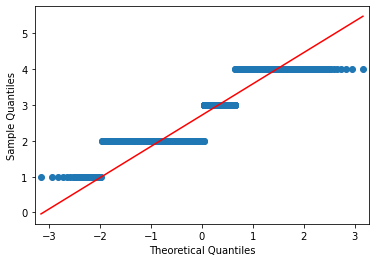

In [9]:
#QQ plot to conform lack of normality
sm.qqplot(atl_df_spring_dst['severity'], line='s');

In [10]:
#Levene's test of 
stats.levene(atl_df['severity'][atl_df['week'] == 10],
              atl_df['severity'][atl_df['week'] == 11],
              atl_df['severity'][atl_df['week'] == 12])

LeveneResult(statistic=10.096230113221944, pvalue=4.468234682486448e-05)

In [11]:
stats.kruskal(atl_df['severity'][atl_df['week'] == 10],
              atl_df['severity'][atl_df['week'] == 11],
              atl_df['severity'][atl_df['week'] == 12])

KruskalResult(statistic=30.020383312312738, pvalue=3.028005024142762e-07)

### Tukey Honestly Significant Difference (HSD) Test

In [18]:
atl_df_spring_dst['week'] = atl_df_spring_dst.week.map({10 : 'Week Before', 11 : 'Week of DST', 12: 'Week After'})
atl_df_spring_dst.head(2)

<ipython-input-18-1fb9b8ff5698>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atl_df_spring_dst['week'] = atl_df_spring_dst.week.map({10 : 'Week Before', 11 : 'Week of DST', 12: 'Week After'})


,severity,start_lat,start_lng,end_lat,end_lng,distance(mi),temperature(f),wind_chill(f),humidity(%),pressure(in),...,weather_condition_Light Snow and Sleet,weather_condition_Haze / Windy,weather_condition_Heavy Snow,weather_condition_Freezing Rain,weather_condition_Heavy Snow / Windy,weather_condition_Light Freezing Fog,weather_condition_Blowing Dust / Windy,weather_condition_Heavy Blowing Snow,weather_condition_Light Freezing Drizzle,is_DST
3231,4,33.24735,-84.290017,33.24740,-84.284873,0.297,42.8,42.8,76.0,30.48,...,0,0,0,0,0,0,0,0,0,0
3232,3,33.56161,-84.314500,33.56765,-84.324130,0.694,59.0,59.0,35.0,30.51,...,0,0,0,0,0,0,0,0,0,0


In [19]:
atl_df_spring_dst['week'].value_counts()

Week Before    467
Week After     430
Week of DST    362
Name: week, dtype: int64

In [20]:
comp = mc.MultiComparison(atl_df_spring_dst['severity'], atl_df_spring_dst['week'], 
                         group_order=['Week Before', 'Week of DST', 'Week After'])
post_hoc = comp.tukeyhsd()
post_hoc.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Week Before,Week of DST,-0.0074,0.9,-0.1492,0.1345,False
Week Before,Week After,-0.2967,0.001,-0.4321,-0.1613,True
Week of DST,Week After,-0.2893,0.001,-0.4338,-0.1448,True


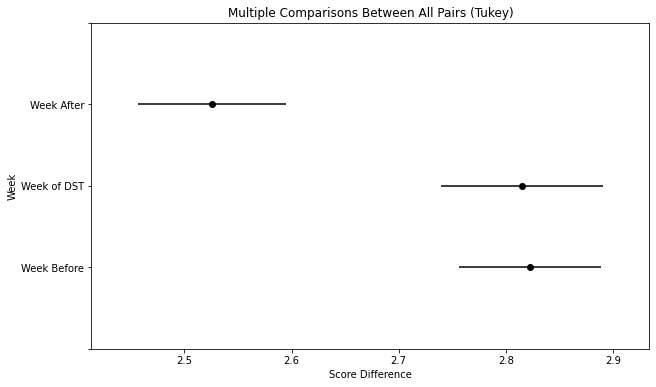

In [21]:
post_hoc.plot_simultaneous(ylabel='Week', xlabel='Score Difference');

### Bonferroni Correction

In [22]:
tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method='bonf')
tbl

group1,group2,stat,pval,pval_corr,reject
Week Before,Week of DST,0.1202,0.9043,1.0,False
Week Before,Week After,5.2435,0.0,0.0,True
Week of DST,Week After,4.6551,0.0,0.0,True


In [47]:
chi_df_spring_dst.groupby('week').mean()

,severity,start_lat,start_lng,end_lat,end_lng,distance(mi),temperature(f),wind_chill(f),humidity(%),pressure(in),...,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,weather_condition_Light Snow and Sleet,is_DST
week,,,,,,,,,,,,,,,,,,,,,
10,2.759259,41.971090,-87.844087,41.971160,-87.844042,0.378793,41.404630,36.361667,61.195683,29.898611,...,0.107407,0.118519,0.074074,0.027778,0.020370,0.014815,0.029630,0.027778,0.0,0.644444
11,2.626362,41.956557,-87.859411,41.956819,-87.859643,0.278264,34.605338,27.270479,73.103486,30.017669,...,0.080610,0.071895,0.049020,0.033769,0.021786,0.025054,0.028322,0.028322,0.0,0.464052
12,2.697479,41.938544,-87.859321,41.938944,-87.859486,0.228887,44.143137,40.588095,70.200280,29.822913,...,0.078431,0.060224,0.050420,0.023810,0.022409,0.028011,0.019608,0.036415,0.0,0.000000


### Sidak Correction 

In [23]:
tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method='sidak')
tbl

group1,group2,stat,pval,pval_corr,reject
Week Before,Week of DST,0.1202,0.9043,0.9991,False
Week Before,Week After,5.2435,0.0,0.0,True
Week of DST,Week After,4.6551,0.0,0.0,True


### Interpretation

* Based on the results of the ANOVA and Kruskall-Wallace tests we can see that there is a significant difference in the severity of traffic accidents before, during the week of DST, and after the week of DST.
* Interestingly in Atlanta we saw a difference in the week before DST and the week after DST and the week of DST and the week after DST. 